In [1]:
import numpy as np
import matplotlib.pyplot as plt

from GmGM import GmGM
from GmGM.synthetic import PrecMatGenerator, DatasetGenerator
from GmGM.synthetic import PrecMatErdosRenyiGilbert
from GmGM.synthetic import measure_prec_recall, plot_prec_recall

Note: I think in this notebook, precision/recall have been flipped...  Keep that in mind while reading!  Am working on a fix.

## Main Takeaways

After looking at the experiments here, the main takeaways are:

- Tensor data is "easy", even with a single sample.  Use "overall" thresholding
- Matrix data is harder; use "rowwise-col-weighted" thresholding if you only have a single sample (otherwise use "overall")
- If your data is normally distributed, using a small `n_comps` will harm performance substantially (but may be the only option for very large datasets)
- If your data is not normally distributed, using a small `n_comps` is no longer a substantial harm, and will usually substantially improve performance!  Furthermore, "rowwise-col-weighted" is better than "overall" thresholding, even when there is only a single sample.

## Experiment One
Synthetic multi-omics dataset, where true graphs are sparse.

We see that when we only have one sample (common real-world case), it's better to use col-weighted rowwise thresholding.  However, if we have a few samples (here `num_samples=10`), overall thresholding does better.

We also see that shared axes ("cell" here) get better results.

In [2]:
generator = DatasetGenerator(
    structure={
        "rna": ("cell", "gene"),
        "atac": ("cell", "peak"),
    },
    generator={
        "cell": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "gene": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "peak": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
    },
    size={
        "cell": 200,
        "gene": 200,
        "peak": 200
    },
)
generator

<DatasetGenerator, structure=
	rna: ('', 'cell', 'gene')
	atac: ('', 'cell', 'peak')
size=
	cell: 200
	gene: 200
	peak: 200
generator=
	cell: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	gene: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	peak: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
axis_join=
	Kronecker Sum
distribution=
	rna: <Normal Distribution>
	atac: <Normal Distribution>
>

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


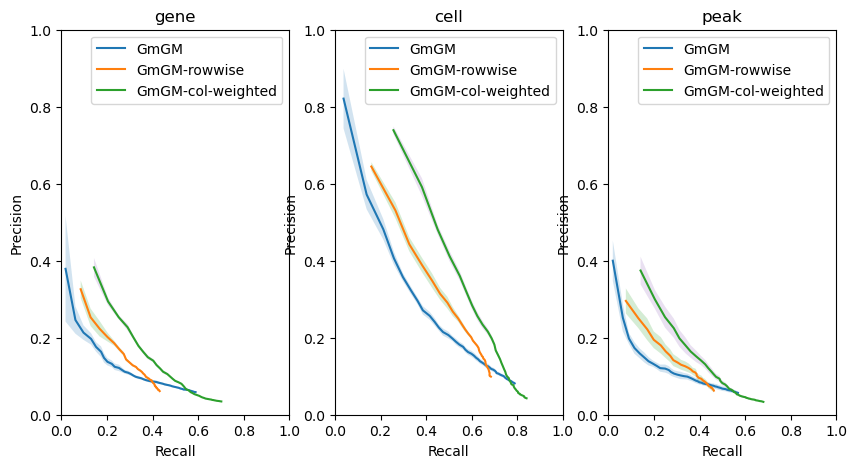

In [3]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted")
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


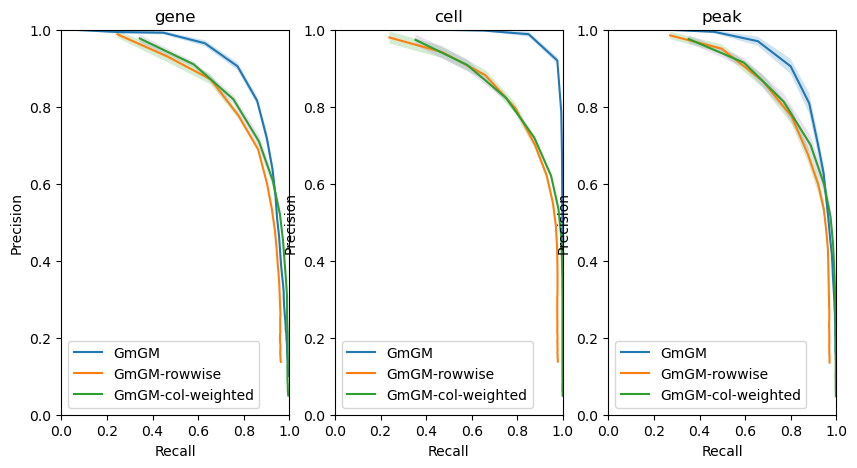

In [4]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted")
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

## Experiment Two

When is the principal components approximation okay?

On synthetic data I am not able to make it look okay!  I know from experiments that this approximation is able to work on real data, so more work needs to be done on figuring out why it does not work on synthetic data.

In [5]:
generator = DatasetGenerator(
    structure={
        "rna": ("cell", "gene"),
        "atac": ("cell", "peak"),
    },
    generator={
        "cell": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
        "gene": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
        "peak": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
    },
    size={
        "cell": 200,
        "gene": 200,
        "peak": 200
    },
)
generator

<DatasetGenerator, structure=
	rna: ('', 'cell', 'gene')
	atac: ('', 'cell', 'peak')
size=
	cell: 200
	gene: 200
	peak: 200
generator=
	cell: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
	gene: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
	peak: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
axis_join=
	Kronecker Sum
distribution=
	rna: <Normal Distribution>
	atac: <Normal Distribution>
>

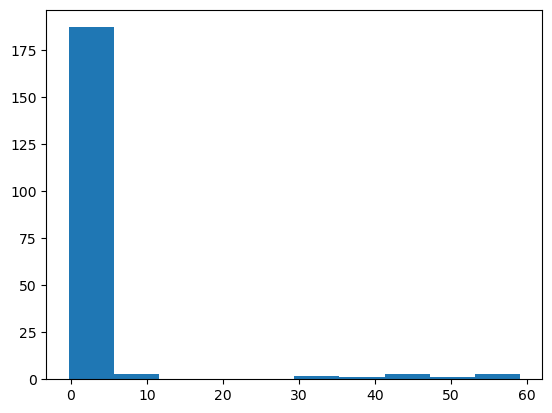

In [6]:
generator.generate()
plt.hist(np.linalg.eigh(generator.Psis["cell"])[0])
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


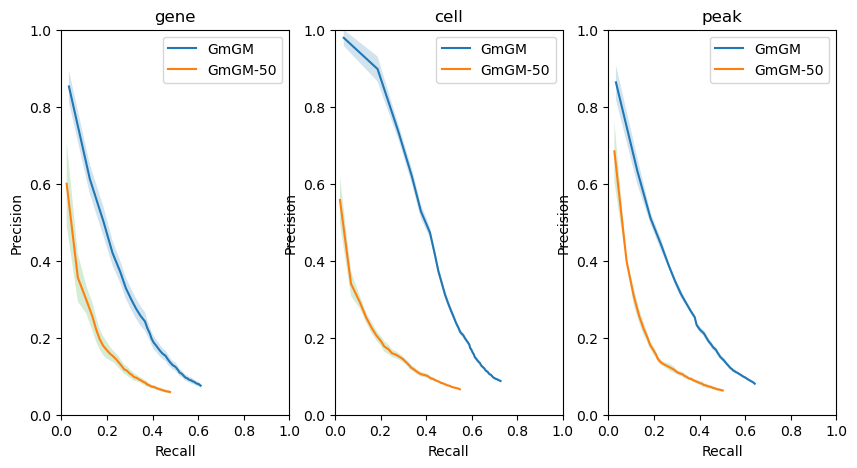

In [7]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", n_comps=50),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-50": np.linspace(0.001, 0.2, 50)
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


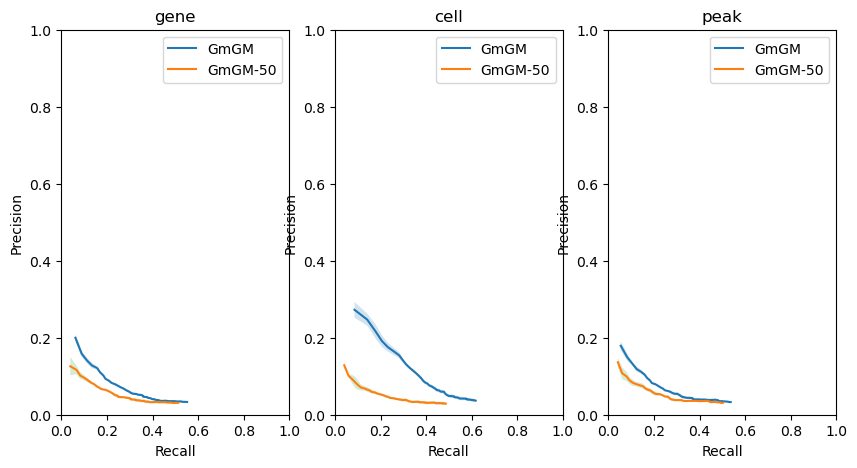

In [8]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted", n_comps=50),
    },
    Lambdas={
        "GmGM": np.arange(1, 51),
        "GmGM-50": np.arange(1, 51),
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


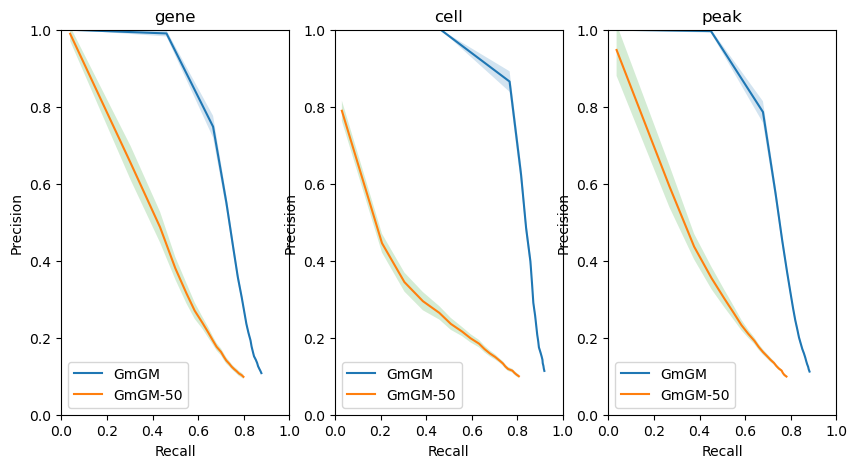

In [10]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", n_comps=50),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 20),
        "GmGM-50": np.linspace(0.001, 0.2, 20),
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


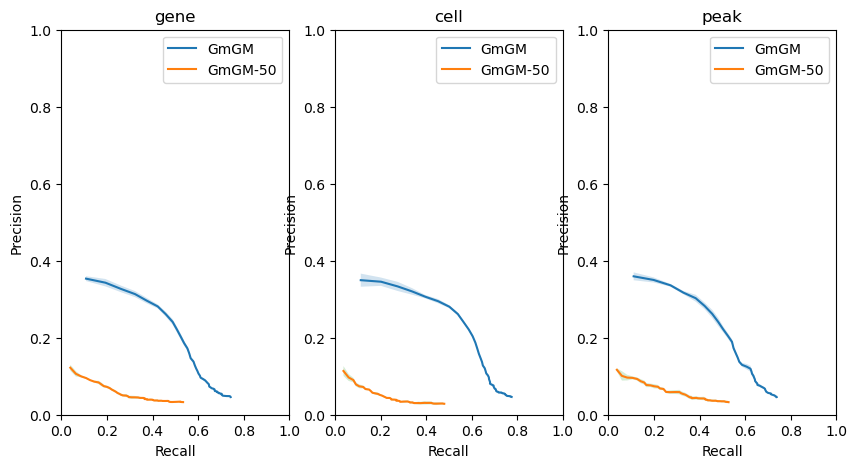

In [11]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted", n_comps=50),
    },
    Lambdas={
        "GmGM": np.arange(1, 51),
        "GmGM-50": np.arange(1, 51),
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

## Experiment Three: Tensor Data

Best to do "overall" thresholding, and we get near-perfect performance with only one sample.  This makes sense as in tensor data, we have "many more" samples (an AxBxC tensor has BC data points for each element along the A axis, compared to an AxB matrix which only has B data points).

In [12]:
generator = DatasetGenerator(
    structure={
        "tensor": ("A", "B", "C"),
    },
    generator={
        "A": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "B": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "C": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
    },
    size={
        "A": 50,
        "B": 50,
        "C": 50
    },
)
generator

<DatasetGenerator, structure=
	tensor: ('', 'A', 'B', 'C')
size=
	A: 50
	B: 50
	C: 50
generator=
	A: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	B: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	C: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
axis_join=
	Kronecker Sum
distribution=
	tensor: <Normal Distribution>
>

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


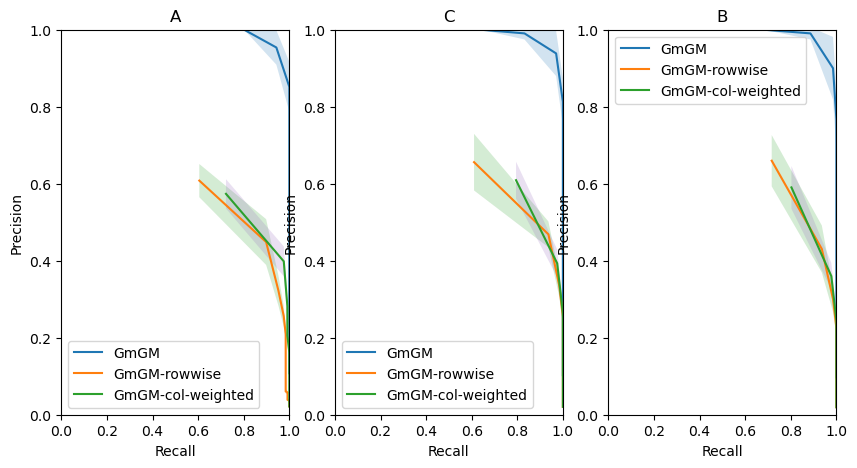

In [13]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted")
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=1,
    verbose=1
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


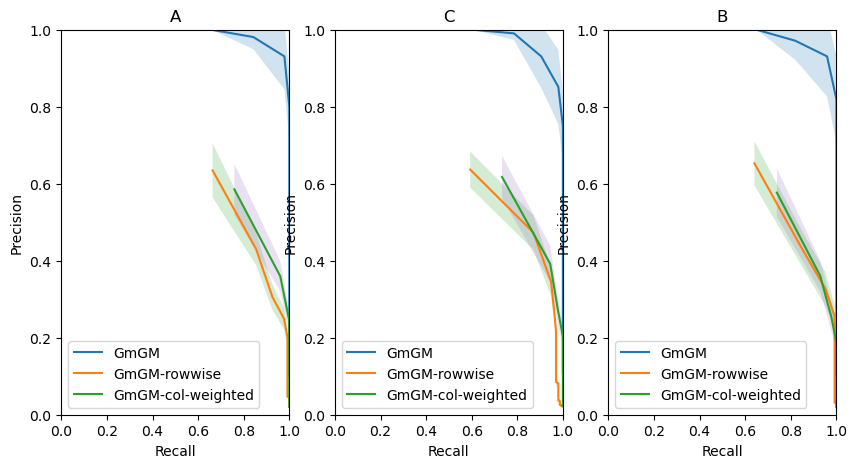

In [14]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted")
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=10,
    verbose=1
)
plot_prec_recall(results, figsize=(10, 5))
pass

## Experiment Four: Tensor Data, n_comps << size

In [19]:
generator = DatasetGenerator(
    structure={
        "tensor": ("A", "B", "C"),
    },
    generator={
        "A": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
        "B": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
        "C": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
    },
    size={
        "A": 50,
        "B": 50,
        "C": 50
    },
)
generator

<DatasetGenerator, structure=
	tensor: ('', 'A', 'B', 'C')
size=
	A: 50
	B: 50
	C: 50
generator=
	A: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
	B: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
	C: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
axis_join=
	Kronecker Sum
distribution=
	tensor: <Normal Distribution>
>

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


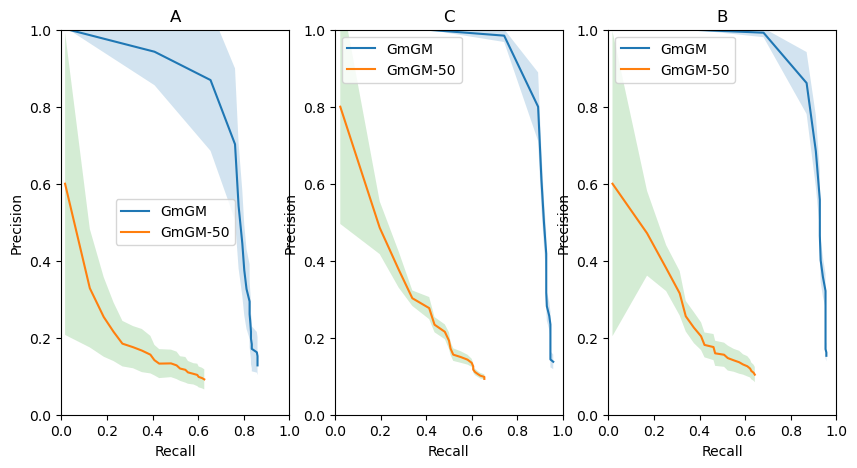

In [20]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", n_comps=20),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 20),
        "GmGM-50": np.linspace(0.001, 0.2, 20),
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


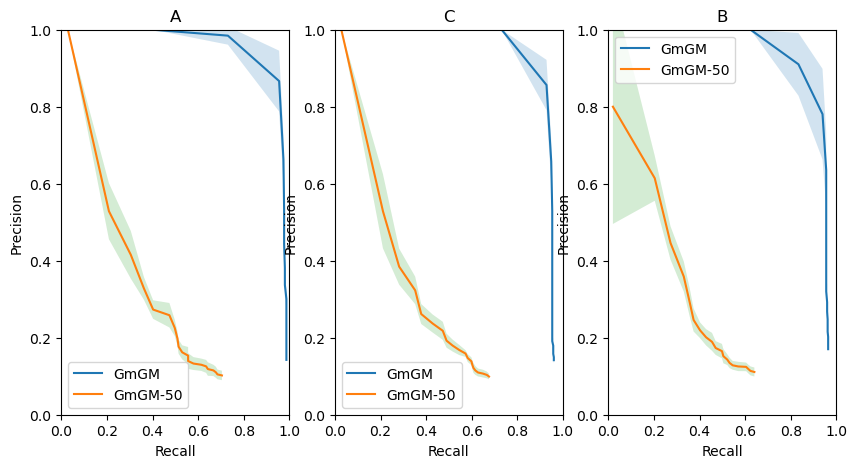

In [21]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", n_comps=20),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 20),
        "GmGM-50": np.linspace(0.001, 0.2, 20),
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

## Experiment Five: Non-normal data

The col-weighting method is the only one that works on non-normal data, it seems.

In [22]:
generator = DatasetGenerator(
    structure={
        "rna": ("cell", "gene"),
        "atac": ("cell", "peak"),
    },
    generator={
        "cell": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "gene": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "peak": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
    },
    size={
        "cell": 200,
        "gene": 200,
        "peak": 200
    },
    distribution="Log Normal"
)
generator

<DatasetGenerator, structure=
	rna: ('', 'cell', 'gene')
	atac: ('', 'cell', 'peak')
size=
	cell: 200
	gene: 200
	peak: 200
generator=
	cell: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	gene: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
	peak: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02)>
axis_join=
	Kronecker Sum
distribution=
	rna: <Log Normal Distribution>
	atac: <Log Normal Distribution>
>

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


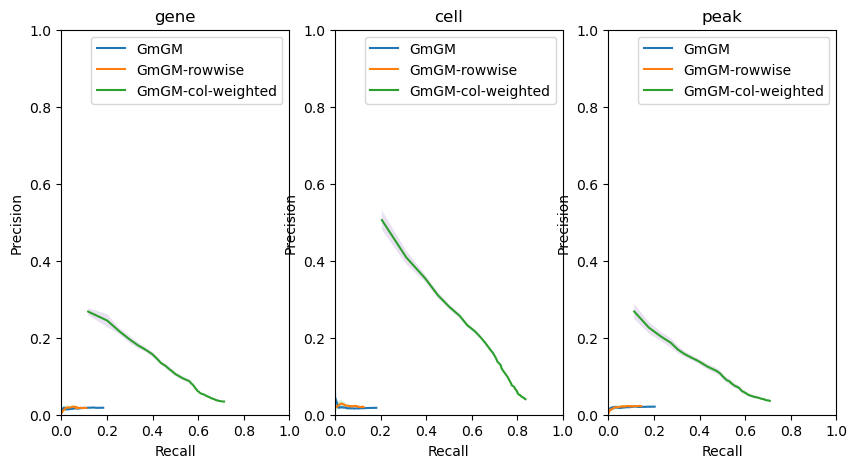

In [23]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted")
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


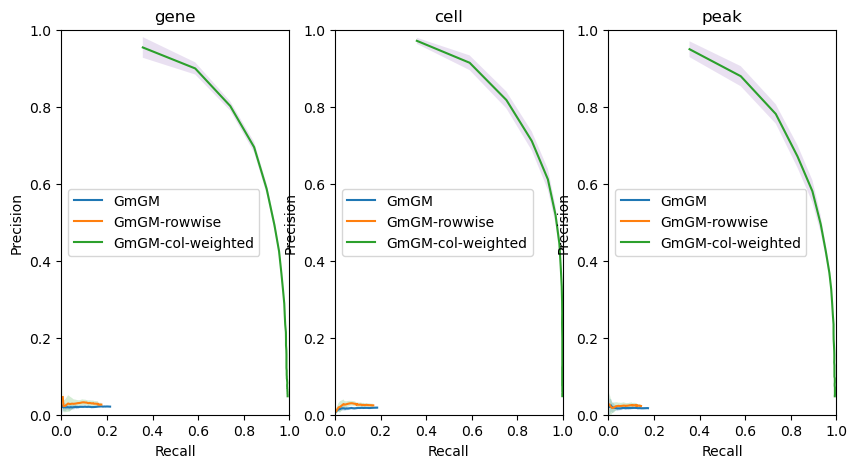

In [24]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted")
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

## Experiment Six: Non-normal data, n_comps << size

**On non-normal data, the pricipal components approximation seems to do better than without it!!** (At least in some regimes)

In [25]:
generator = DatasetGenerator(
    structure={
        "rna": ("cell", "gene"),
        "atac": ("cell", "peak"),
    },
    generator={
        "cell": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
        "gene": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
        "peak": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
    },
    size={
        "cell": 200,
        "gene": 200,
        "peak": 200
    },
    distribution="Log Normal"
)
generator

<DatasetGenerator, structure=
	rna: ('', 'cell', 'gene')
	atac: ('', 'cell', 'peak')
size=
	cell: 200
	gene: 200
	peak: 200
generator=
	cell: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
	gene: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
	peak: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
axis_join=
	Kronecker Sum
distribution=
	rna: <Log Normal Distribution>
	atac: <Log Normal Distribution>
>

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


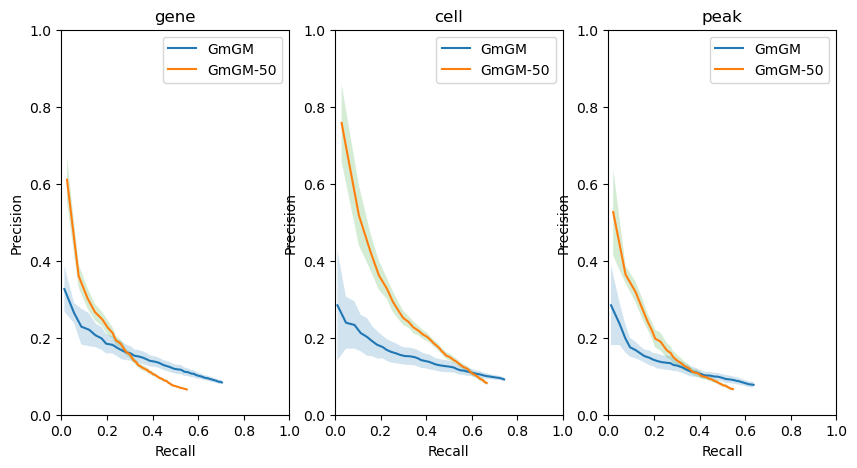

In [26]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", n_comps=50),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-50": np.linspace(0.001, 0.2, 50)
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


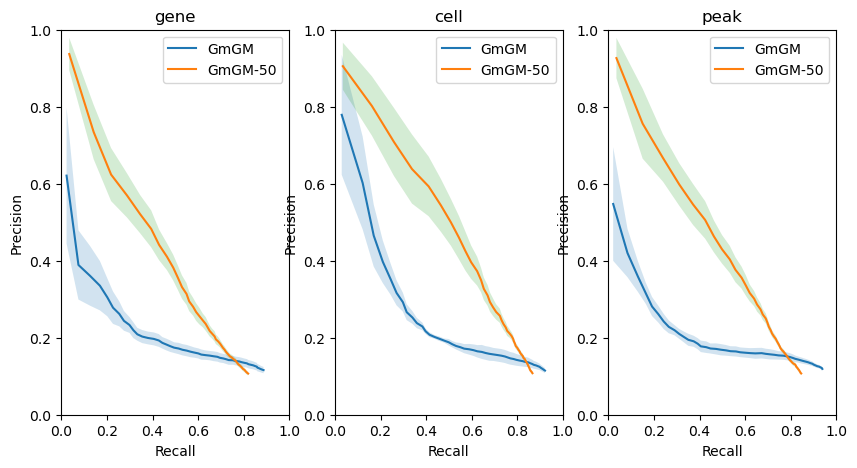

In [27]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-50": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall", n_comps=50),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-50": np.linspace(0.001, 0.2, 50)
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

## Experiment Seven: Non-normal tensor data

In [28]:
generator = DatasetGenerator(
    structure={
        "tensor": ("A", "B", "C"),
    },
    generator={
        "A": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
        "B": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
        "C": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            n_comps=10
        ),
    },
    size={
        "A": 50,
        "B": 50,
        "C": 50
    },
    distribution="Log Normal"
)
generator

<DatasetGenerator, structure=
	tensor: ('', 'A', 'B', 'C')
size=
	A: 50
	B: 50
	C: 50
generator=
	A: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
	B: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
	C: <PrecMatGenerator, core=coreless, mask=PrecMatErdosRenyiGilbert(edge_probability=0.02), n_comps=10>
axis_join=
	Kronecker Sum
distribution=
	tensor: <Log Normal Distribution>
>

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


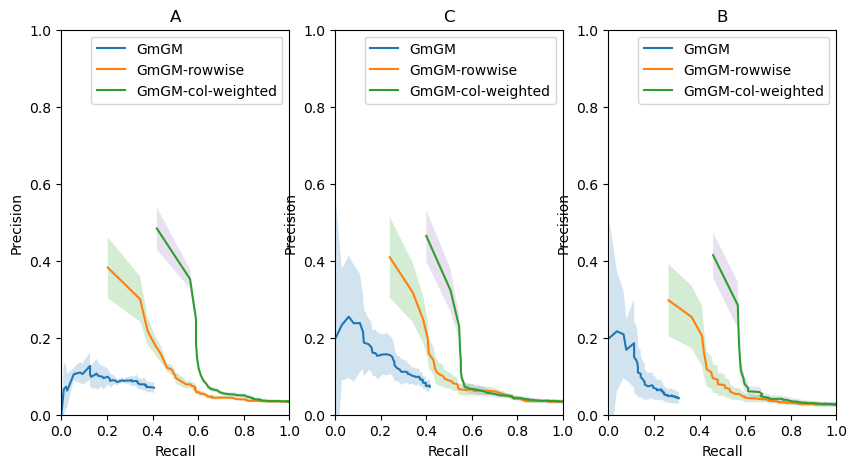

In [29]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted")
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=1,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


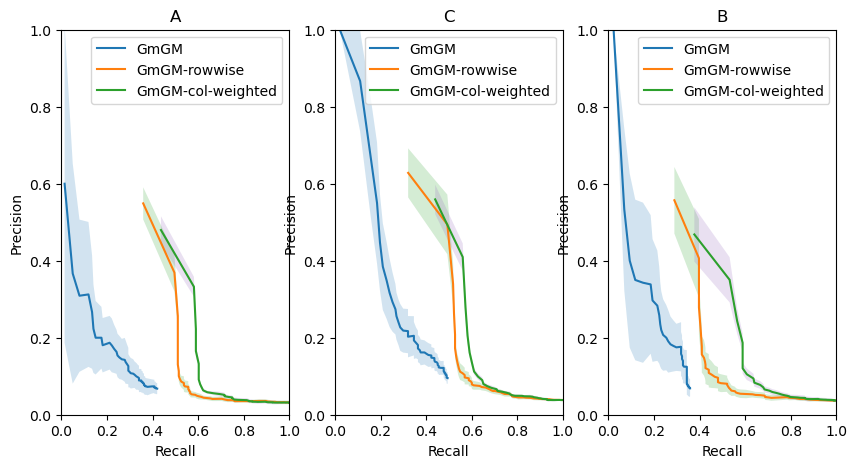

In [30]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
        "GmGM-rowwise": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise"),
        "GmGM-col-weighted": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="rowwise-col-weighted")
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 0.2, 50),
        "GmGM-rowwise": np.arange(1, 51),
        "GmGM-col-weighted": np.arange(1, 51)
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(results, figsize=(10, 5))
pass